In [1]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [2]:
example_file_maxquant = "../../test_data/system_tests/organellar_maps/evidence.txt.protgroup_annotated.tsv.maxquant_evidence.aq_reformat.tsv"
example_file_maxquant = "../../test_data/system_tests/organellar_maps/evidence.txt.protgroup_annotated.tsv.ion_intensities.tsv"
protein_groups_file = "../../test_data/system_tests/organellar_maps/proteinGroups.txt"
directlfq_file = "../../test_data/system_tests/organellar_maps/evidence.txt.protgroup_annotated.tsv.protein_intensities.tsv"
evidence_file = "../../test_data/system_tests/organellar_maps/evidence.txt"
evidence_file_annotated = "../../test_data/system_tests/organellar_maps/evidence.txt.protgroup_annotated.tsv"
aq_reformat_file = "/Users/constantin/workspace/directlfq/test_data/system_tests/organellar_maps/evidence.txt.protgroup_annotated.tsv.maxquant_evidence.aq_reformat.tsv"
image_save_path = "/Users/constantin/workspace/directlfq/test_data/system_tests/organellar_maps/protein_traces/"

In [3]:
import pandas as pd

def find_protid_by_genename(gene2id_dict, gene_name):
    return gene2id_dict.get(gene_name)

def get_gene2id_dict(protein_groups_file):
    protein_groups_df = pd.read_csv(protein_groups_file, sep = "\t", usecols = ["Protein IDs", "Gene names"])
    #map dict from gene name to list of protein ids
    gene2id_dict = {}
    for index, row in protein_groups_df.iterrows():
        gene = row["Gene names"]
        protid = row["Protein IDs"]
        if gene in gene2id_dict:
            gene2id_dict[gene].append(protid)
        else:
            gene2id_dict[gene] = [protid]

    return gene2id_dict


gene2id_dict = get_gene2id_dict(protein_groups_file)

In [4]:
protid = find_protid_by_genename(gene2id_dict, "AVEN")
print(protid)

['Q9NQS1']


In [5]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import directlfq.visualizations as lfq_viz

import directlfq.utils as lfq_utils


def load_mq_dataframe(example_mq_file):
    mq_df = pd.read_csv(example_mq_file, sep = "\t")
    mq_df = lfq_utils.index_and_log_transform_input_df(mq_df)
    mq_df = mq_df.reindex(sorted(mq_df.columns, key= lambda x : get_fraction_number(x)), axis=1)
    return mq_df

def load_protein_groups_df(protein_groups_file):
    protein_groups_df = pd.read_csv(protein_groups_file, sep = "\t")
    protein_groups_df = protein_groups_df.rename(columns = {"Protein IDs" : "protein"})
    protein_groups_df = protein_groups_df.set_index("protein")
    protein_groups_lfq_columns = [x for x in protein_groups_df.columns if x.startswith("LFQ")]
    protein_groups_df_subset = protein_groups_df[protein_groups_lfq_columns]
    protein_groups_df_subset_logged = protein_groups_df_subset.replace(0, np.nan).apply(np.log2)
    protein_groups_df_subset_logged = protein_groups_df_subset_logged.reindex(sorted(protein_groups_df_subset_logged.columns, key= lambda x : get_fraction_number(x)), axis=1)
    protein_groups_df_subset_logged.columns = [x.replace("LFQ intensity ", "") for x in protein_groups_df_subset_logged.columns]
    return protein_groups_df_subset_logged

def load_directlfq_df(directlfq_file):
    directlfq_df = pd.read_csv(directlfq_file, sep = "\t")
    directlfq_df = directlfq_df.drop(columns = ["Gene names", "Protein IDs"])
    directlfq_df = directlfq_df.set_index("protein")
    directlfq_df = directlfq_df.replace(0, np.nan).apply(np.log2)
    directlfq_df = directlfq_df.reindex(sorted(directlfq_df.columns, key= lambda x : get_fraction_number(x)), axis=1)
    return directlfq_df

def filter_df_for_map(df, map):
    #get columns with non-numeric type from a dataframe
    non_numeric_columns = list(df.select_dtypes(exclude=[np.number]).columns)
    map_columns = [x for x in df.columns if map in x and "Cyt" not in x]
    df_shortened = df[map_columns + non_numeric_columns]
    return df_shortened

def get_fraction_number(fraction_name):
    shortened_fraction = fraction_name.split("_")[1].replace("K", "")
    try:
        return int(shortened_fraction)
    except:
        return np.inf

ion_df = load_mq_dataframe(example_file_maxquant)
protein_groups_df = load_protein_groups_df(protein_groups_file)
directlfq_df = load_directlfq_df(directlfq_file)

ion_df_mapfilt = filter_df_for_map(ion_df, "Map")
protein_groups_df_mapfilt = filter_df_for_map(protein_groups_df, "Map")
directlfq_df_mapfilt = filter_df_for_map(directlfq_df, "Map")

/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_9341/1603866084.py:17: DtypeWarning: Columns (221) have mixed types. Specify dtype option on import or set low_memory=False.
  protein_groups_df = pd.read_csv(protein_groups_file, sep = "\t")


In [6]:
import directlfq.protein_intensity_estimation as lfq_protint


def get_protein_profile_matched_to_ions(protein_df, ion_df, selected_prot):
    protein_values = protein_df.loc[[selected_prot]].values[0]
    ion_values = ion_df.loc[[selected_prot]]
    median_ion_values = np.nanmedian(ion_values, axis = 0)
    shifted_protein_values =  shift_protein_profile_to_median_ion_profile(protein_values, median_ion_values)
    shifted_protein_values = shifted_protein_values[~np.isnan(shifted_protein_values)]
    return shifted_protein_values


def shift_protein_profile_to_median_ion_profile(protein_values, median_ion_values):
    shift = np.nanmedian(protein_values - median_ion_values)
    return protein_values - shift


def compare_maxquant_and_directlfq(ion_df, maxlfq_df, directlfq_df, selected_prot, ax):
    colorlist = lfq_viz.AlphaPeptColorMap().colorlist_hex
    color_directlfq = colorlist[0]
    color_mq = colorlist[1]

    protein_df = ion_df.loc[[selected_prot]]
    #lfq_viz.IonTraceVisualizer( protein_df, ax)
    lfq_viz.IonTraceCompararisonPlotterNoDirectLFQTrace(ion_df, str(selected_prot), ax=ax)
    maxlfq_values =  get_protein_profile_matched_to_ions(maxlfq_df, ion_df, selected_prot)
    directlfq_values = get_protein_profile_matched_to_ions(directlfq_df, ion_df, selected_prot)
    #maxlfq_values, directlfq_values = get_protein_profiles_maxlfq_directlfq(maxlfq_df, directlfq_df, selected_prot)
    sns.lineplot(x = range(len(maxlfq_values)), y = maxlfq_values, ax=ax,color=color_mq, linewidth=3, linestyle='-')
    sns.lineplot(x = range(len(directlfq_values)), y = directlfq_values, ax=ax,color=color_directlfq, linewidth=3, linestyle='-')
    lines = ax.get_lines()
    lines[-2].set_label("MaxLFQ")
    lines[-1].set_label("directLFQ")
    #get legend handles and labels
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])

    #set all y axes to the same limits
    max_y = max(ax.get_ylim())
    min_y = min(ax.get_ylim())
    ax.set_ylim(min_y, max_y)
    

#re order figure along the x axis

P49721


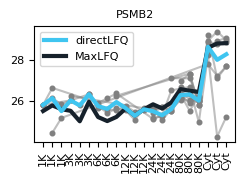

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (2.6, 1.5))

protid = find_protid_by_genename(gene2id_dict, "PSMB2")[0]
print(protid)
compare_maxquant_and_directlfq(ion_df, protein_groups_df, directlfq_df, protid, ax)
ax.set_title("PSMB2")
xticklabels = ax.get_xticklabels()
xticklabels = [x.get_text().replace("Map1_", "").replace("Map2_", "").replace("Map3_", "") for x in xticklabels]
ax.set_xticklabels(xticklabels)
fig.savefig(f"{image_save_path}/PSMB2.pdf", bbox_inches = "tight", dpi = 300, transparent = True)


['P33993;P33993-3;P33993-2']


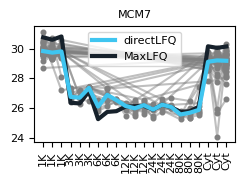

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (2.6, 1.5))
protids = find_protid_by_genename(gene2id_dict, "MCM7")
print(protids)
compare_maxquant_and_directlfq(ion_df, protein_groups_df, directlfq_df, protids[0], ax)
ax.set_title("MCM7")
xticklabels = ax.get_xticklabels()
xticklabels = [x.get_text().replace("Map1_", "").replace("Map2_", "").replace("Map3_", "") for x in xticklabels]
ax.set_xticklabels(xticklabels)
fig.savefig(f"{image_save_path}/MCM7.pdf", bbox_inches = "tight", dpi = 300, transparent = True)

In [9]:
extremes_maxlfq = ["AVEN", "HERC2", "FAM192A", "ASAH1"]
extremes_directlfq = ["AVEN", "ALDH18A1", "FAM192A", "COG5"]
extremes_locations = ["right", "bottom", "left", "top"]

overall_extremes = ["AVEN", "HERC2", "FAM192A", "ASAH1", "ALDH18A1", "COG5"]

Q9NQS1
O95714;Q9BVR0
Q9GZU8
Q13510-2;Q13510;Q13510-3


/Users/constantin/opt/anaconda3/envs/directlfq/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/constantin/opt/anaconda3/envs/directlfq/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/constantin/opt/anaconda3/envs/directlfq/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/constantin/opt/anaconda3/envs/directlfq/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/constantin/opt/anaconda3/envs/directlfq/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWa

P54886;P54886-2
Q9UP83-2;Q9UP83;Q9UP83-3


/Users/constantin/opt/anaconda3/envs/directlfq/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/constantin/opt/anaconda3/envs/directlfq/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/constantin/opt/anaconda3/envs/directlfq/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/constantin/opt/anaconda3/envs/directlfq/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


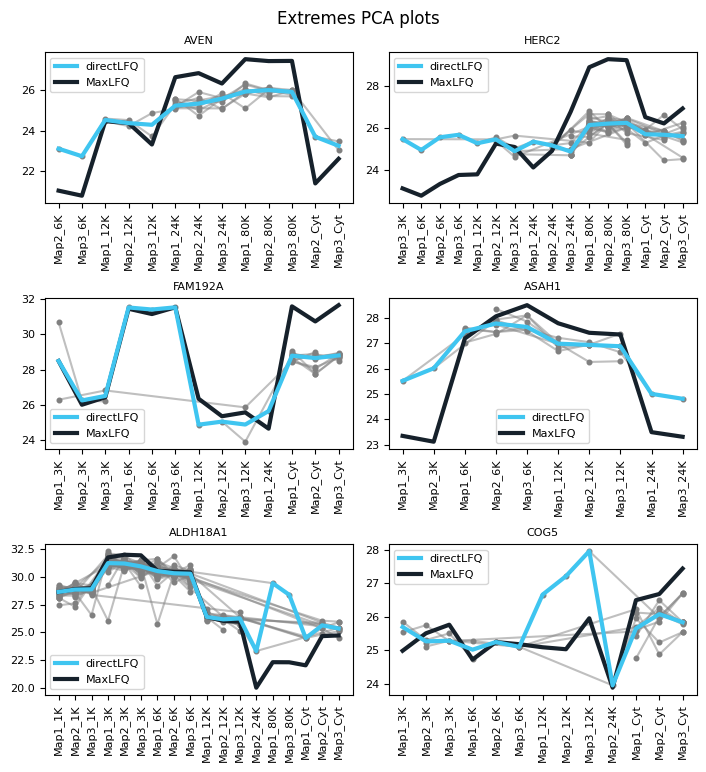

In [10]:
fig, axes = plt.subplots(3, 2, figsize = (7, 7.5))
for idx in range(len(overall_extremes)):
    gene_name = overall_extremes[idx]
    ax = axes.flatten()[idx]
    protid = find_protid_by_genename(gene2id_dict, gene_name)[0]
    print(protid)
    compare_maxquant_and_directlfq(ion_df, protein_groups_df, directlfq_df, protid, ax)
    ax.set_title(gene_name)

fig.tight_layout()

#set title of overall figure
fig.text(0.5, 1, "Extremes PCA plots", ha='center', fontsize=12)
fig.savefig(f"{image_save_path}/extremes_pca_plots.pdf", bbox_inches = "tight", dpi = 300)
fig.savefig(f"{image_save_path}/extremes_pca_plots.png", bbox_inches = "tight", dpi = 300)


### Tests: Check that the underlying ion data is consistent with the MQ evidence.txt

In [11]:
def compare_number_of_datapoints_in_traces_w_protgroup_id_mapping(ion_file, protein_groups_file, evidence_file, list_of_protids_to_check):
    ion_df = load_mq_dataframe(ion_file)
    protein2num_peptides_proteingroups_df = get_protein2num_peptides_proteingroups_df(protein_groups_file, evidence_file)
    protein2num_peptides_ion_df = get_protein2numpeptides_ion_df(ion_df)
    for protid in list_of_protids_to_check:
        num_ions_iondf = protein2num_peptides_ion_df[protid]
        num_ions_proteingroupsdf = protein2num_peptides_proteingroups_df[protid]
        print(f"protid: {protid}, num_ions_iondf: {num_ions_iondf}, num_ions_proteingroupsdf: {num_ions_proteingroupsdf}")
        assert num_ions_iondf == num_ions_proteingroupsdf


def get_protein2num_peptides_proteingroups_df(protein_groups_file, evidence_file):
    protein_groups_df = pd.read_csv(protein_groups_file, sep = "\t", usecols=["Protein IDs", "Evidence IDs"])
    print(evidence_file)
    set_of_valid_evidence_ids = get_set_of_valid_evidence_ids(evidence_file)
    protein2num_peptides = {}
    for _, row in protein_groups_df.iterrows():
        evidence_ids = row["Evidence IDs"].split(";")
        evidence_ids = [x for x in evidence_ids if x in set_of_valid_evidence_ids]
        protid = row["Protein IDs"]
        protein2num_peptides[protid] = len(evidence_ids)
    return protein2num_peptides

def get_set_of_valid_evidence_ids(evidence_file):
    evidence_df = pd.read_csv(evidence_file, usecols=["id", "Intensity", "Sequence", "Modified sequence","Charge", "Raw file"], sep="\t")
    #evidence_df = evidence_df.drop_duplicates(subset=["Sequence", "Modified sequence","Charge", "Raw file"])
    evidence_df = evidence_df[~evidence_df["Intensity"].isna()]
    return set(evidence_df["id"].astype('str'))


def get_protein2numpeptides_ion_df(ion_df):
    ion_df = ion_df.reset_index()
    numeric_columns = ion_df.select_dtypes(include=np.number).columns
    protein2numpeptides = {}
    for protid, df in ion_df.groupby("protein"):
        df_numeric = df[numeric_columns]
        #get number of non nan values in dataframe
        num_non_nan = df_numeric.count().sum()
        protein2numpeptides[protid] = num_non_nan
    return protein2numpeptides


list_of_protids_to_check = ['P35268', 'P33993;P33993-3;P33993-2', "Q9NQS1", "O95714;Q9BVR0", "Q9GZU8", "Q13510-2;Q13510;Q13510-3", "Q9NQS1", "P54886;P54886-2", "Q9GZU8", "Q9UP83-2;Q9UP83;Q9UP83-3"]

compare_number_of_datapoints_in_traces_w_protgroup_id_mapping(aq_reformat_file, protein_groups_file, evidence_file_annotated, list_of_protids_to_check)

../../test_data/system_tests/organellar_maps/evidence.txt.protgroup_annotated.tsv
protid: P35268, num_ions_iondf: 109, num_ions_proteingroupsdf: 109
protid: P33993;P33993-3;P33993-2, num_ions_iondf: 330, num_ions_proteingroupsdf: 330
protid: Q9NQS1, num_ions_iondf: 58, num_ions_proteingroupsdf: 58
protid: O95714;Q9BVR0, num_ions_iondf: 147, num_ions_proteingroupsdf: 147
protid: Q9GZU8, num_ions_iondf: 51, num_ions_proteingroupsdf: 51
protid: Q13510-2;Q13510;Q13510-3, num_ions_iondf: 43, num_ions_proteingroupsdf: 43
protid: Q9NQS1, num_ions_iondf: 58, num_ions_proteingroupsdf: 58
protid: P54886;P54886-2, num_ions_iondf: 541, num_ions_proteingroupsdf: 541
protid: Q9GZU8, num_ions_iondf: 51, num_ions_proteingroupsdf: 51
protid: Q9UP83-2;Q9UP83;Q9UP83-3, num_ions_iondf: 53, num_ions_proteingroupsdf: 53
